Import statements and load data

In [167]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import math
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

data = pd.read_csv("Life Expectancy Data.csv")
data = data.drop(["Country", "Status"], axis=1)
data = data.dropna()

X = data.drop("Life expectancy ", axis = 1)
y = data["Life expectancy "]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

LASSO regression object

In [168]:
class LassoRegression():
    def __init__(self, name, p, beta, step_size, l1_penalty):
        self.name = name
        self.p = p
        self.beta = beta
        self.l1_penalty = l1_penalty
        self.step_size = step_size
    
    def train(self, X_train, y_train, maxiter):
        self.X_means = X_train.mean()
        self.X_std = X_train.std()
        self.y_mean = y_train.mean()
        self.y_std = y_train.std()

        estvec = []
        gvec = []
        bestbeta = self.beta
        minest = math.inf
        for k in range(1, maxiter+1):
            est, g = self.update_weights(X_train, y_train, k)
            estvec.append(est)
            gvec.append(np.linalg.norm(g))
            if estvec[-1] < minest:
                minest = estvec[-1]
                bestbeta = self.beta
            if k % 25 == 0:
                print(f"Finished {k} out of {maxiter} iterations on {self.name}")
        self.beta = bestbeta
        return estvec, gvec

    def update_weights(self, X, y, k):
        est = self.lasso_estimate(X, y)
        g = self.subgradient(X, y)
        self.beta -= self.step_size(g, k) * g
        return est, g

    def predict(self, X):
        norm_X = (X.sub(self.X_means, axis = 1)).div(self.X_std, axis = 1)
        norm_y = norm_X.dot(self.beta)
        return (norm_y * self.y_std) + self.y_mean
    
    def subgradient(self, X, y):
        norm_X = (X.sub(self.X_means, axis = 1)).div(self.X_std, axis = 1)
        norm_y = (y - self.y_mean) / self.y_std
        n = len(norm_y)
        sum = np.sum(norm_X, axis=0)
        g = np.multiply(np.linalg.norm(norm_y - norm_X.dot(self.beta)), sum) * 2 / n
        g += np.sign(self.beta)*self.l1_penalty
        return g
    
    def lasso_estimate(self, X, y):
        norm_X = (X.sub(self.X_means, axis = 1)).div(self.X_std, axis = 1)
        norm_y = (y - self.y_mean) / self.y_std
        pred = norm_X.dot(self.beta)
        return np.linalg.norm(norm_y-pred)**2



Step Sizes

In [169]:
def constant_step_size(g, k):
    alpha = 1
    return alpha

def constant_step_len(g, k):
    gamma = 1
    norm = np.linalg.vector_norm(g)
    return gamma/norm

def square_sum_not_sum(g, k):
    a = 10
    b = 1
    return a/(b+k)

def nonsum_dim_size(g, k):
    a = 2
    return a / math.sqrt(k)

def nonsum_dim_len(g,k):
    a = 2
    gammak = a / math.sqrt(k)
    norm = np.linalg.vector_norm(g)
    return gammak/norm

Train and test model

In [ ]:
p = len(X_train.columns)
beta = np.random.standard_normal(p)
models = [LassoRegression("Constant Size", p, beta.copy(), constant_step_size, 1e-1),
          LassoRegression("Constant Length", p, beta.copy(), constant_step_len, 1e-1),
          LassoRegression("Sq. Sum. not Sum.", p, beta.copy(), square_sum_not_sum, 1e-1),
          LassoRegression("Nonsum. Dim. Size", p, beta.copy(), nonsum_dim_size, 1e-1),
          LassoRegression("Nonsum. Dim. Length", p, beta.copy(), nonsum_dim_len, 1e-1)]
maxiter = 50

train_results = [model.train(X_train, y_train, maxiter) for model in models]
test_lassos = [model.lasso_estimate(X_test, y_test) for model in models]
print(test_lassos)

Finished 25 out of 50 iterations on Constant Size
Finished 50 out of 50 iterations on Constant Size
Finished 25 out of 50 iterations on Constant Length
Finished 50 out of 50 iterations on Constant Length
Finished 25 out of 50 iterations on Sq. Sum. not Sum.
Finished 50 out of 50 iterations on Sq. Sum. not Sum.
Finished 25 out of 50 iterations on Nonsum. Dim. Size
Finished 50 out of 50 iterations on Nonsum. Dim. Size
Finished 25 out of 50 iterations on Nonsum. Dim. Length
Finished 50 out of 50 iterations on Nonsum. Dim. Length
[np.float64(474.14871824832295), np.float64(1210.814219445006), np.float64(421.46027423513397), np.float64(652.648101226499), np.float64(358.7892918097035)]


Generate Plots

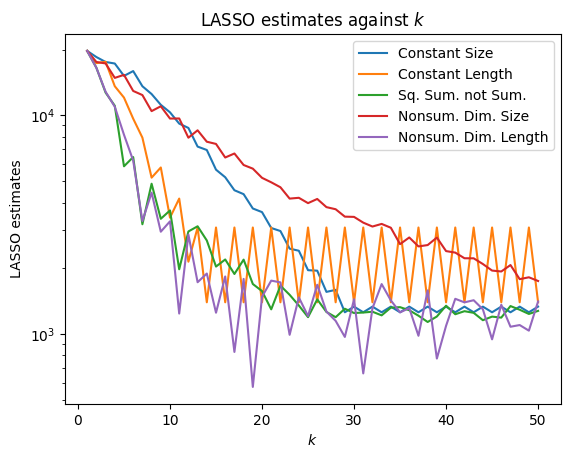

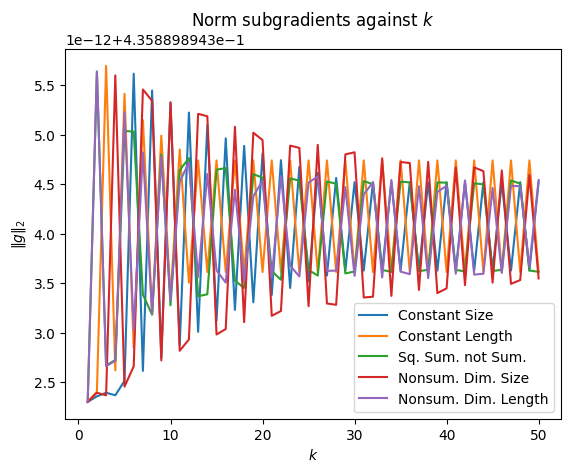

In [171]:
karr = list(range(1, maxiter + 1))

fig, ax = plt.subplots()
for i in range(len(models)):
    ax.plot(karr, train_results[i][0], label=models[i].name)
ax.set_title("LASSO estimates against $k$")
ax.set_ylabel("LASSO estimates")
ax.set_xlabel("$k$")
ax.set_yscale('log')
ax.legend()

fig2, ax2 = plt.subplots()
for i in range(len(models)):
    ax2.plot(karr, train_results[i][1], label=models[i].name)
ax2.set_title("Norm subgradients against $k$")
ax2.set_ylabel("$\\|g\\|_2$")
ax2.set_xlabel("$k$")
ax2.legend()

plt.show()